# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [ ]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

In [ ]:
# TODO: Change the following to your github repo path
#repo_path = 'https://github.com/TLKline/AIHC-5010-Winter-2026.git'
#!git clone {repo_path} student_repo

In [ ]:
# Move into repo
#%cd student_repo

# Repo git info
#!git status

# Where are we?
#print('----------')
#print('We are at:')
#!pwd


## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [ ]:
!pip -q install -r Project-1/readmit30/requirements.txt

## 3) Enable pre-commit hook to strip notebook outputs

This prevents giant notebooks and reduces merge/diff pain.

One-time per clone:
- `pre-commit install`

After that, every `git commit` will strip outputs from `*.ipynb`.


In [ ]:
#!pip -q install pre-commit
#!pre-commit install


# MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [1]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "../../../Project-1/readmit30/scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "../../../Project-1/readmit30/scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "../../../Project-1/readmit30/scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "../../../predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: ../../../Project-1/readmit30/scripts/data/public/train.csv
DEV_PATH: ../../../Project-1/readmit30/scripts/data/public/dev.csv
TEST_PATH: ../../../Project-1/readmit30/scripts/data/public/public_test.csv
OUT_PATH: ../../../predictions.csv


In [2]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

method = 5

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

if method == 5:
    # Improvement: Grid Search for optimal HGB parameters
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    base_model = HistGradientBoostingClassifier(
        random_state=42,
        class_weight='balanced',
        early_stopping=True,
    )

    # Define the pipeline for HGB
    hgb_pipeline = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", base_model),
    ])

    # Define a smaller parameter grid for demonstration
    param_grid = {
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.05, 0.1],
        'model__max_iter': [100, 200]
    }

    # Perform Grid Search
    grid_search = GridSearchCV(hgb_pipeline, param_grid, cv=2, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found:", grid_search.best_params_)
    clf = grid_search.best_estimator_

clf.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters found: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_iter': 200}


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [4]:
p_test = clf.predict_proba(test)[:, 1]
pred = pd.DataFrame({"row_id": test["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

,row_id,prob_readmit30
0,103521306,0.521483
1,127919112,0.727745
2,233245326,0.633598
3,236785056,0.381567
4,131110896,0.354715


In [5]:
# Validate output format (required for students before tagging)
!python ../../../Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


OK: predictions.csv format is valid.


AUROC: 0.6908
AUPRC: 0.2350
Brier Score: 0.2212


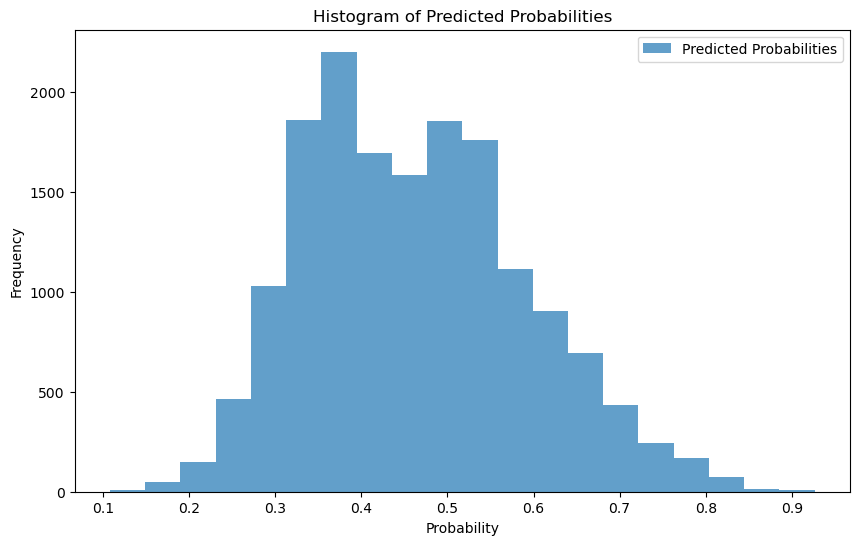

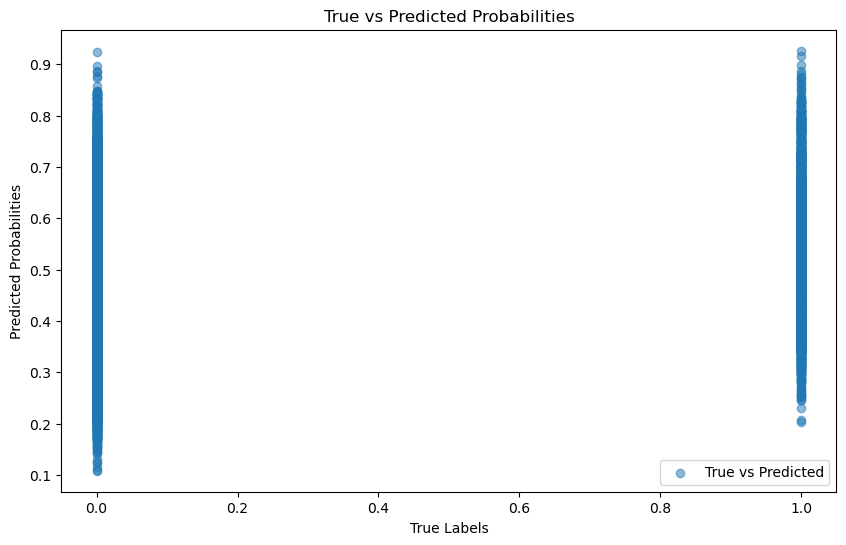

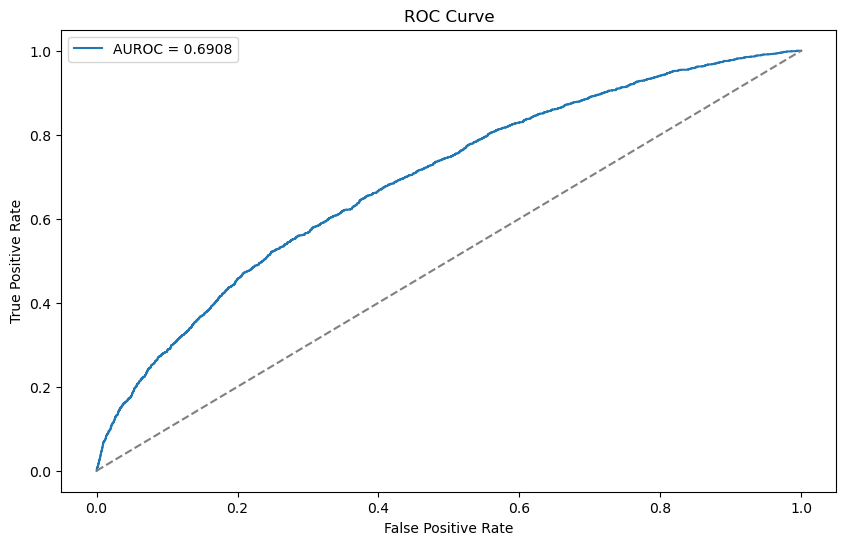

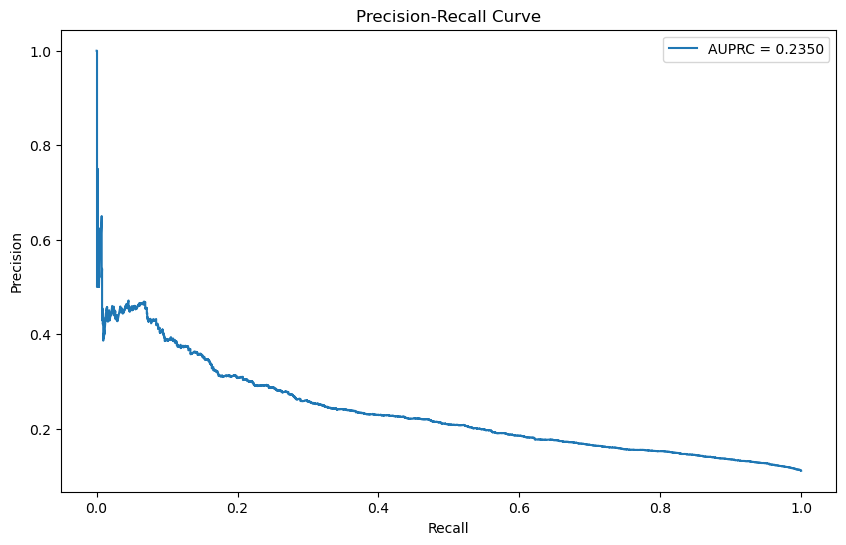

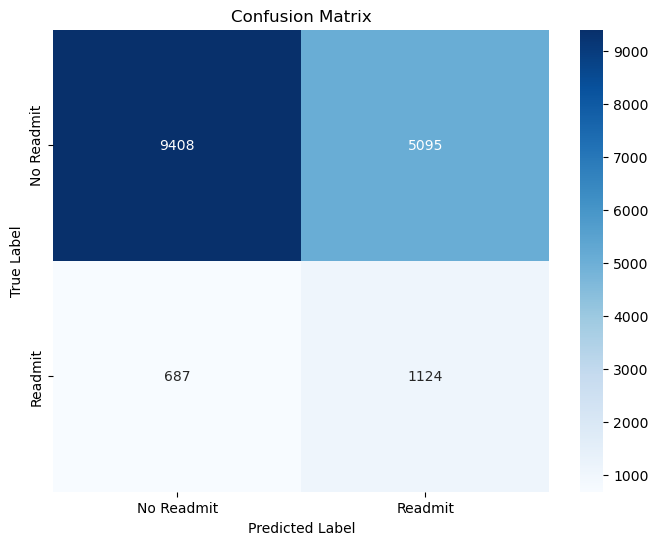

In [6]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# EDA Assignment Start

In [7]:
#Problem 1

# Report rows x colunms
print(f"Rows x Columns: {X_train.shape}")

# Report outcome column name (readmit30) and overall readmission rate
print(f"Outcome Column: {y_train.name}")
print(f"Readmission Rate: {y_train.mean():.2%}")

# Report data types summary (how many numeric vs categorical)
print("\nData Types Summary:")
print(X_train.dtypes.value_counts())

df = pd.read_csv(TRAIN_PATH)

df.head()

Rows x Columns: (65003, 50)
Outcome Column: readmit30
Readmission Rate: 11.16%

Data Types Summary:
object    36
int64     14
Name: count, dtype: int64


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id,readmit30
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,2278392,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,149190,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,16680,0
3,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,35754,0
4,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,Yes,63768,0


Multiple DataFrames found. Using the first one:
['train', 'test', 'X_train', '_4', 'pred', 'dev', 'X_dev', '_7', 'df']
Using DataFrame: `train` with shape (65003, 51)


,missing_count,missing_pct
max_glu_serum,61584,94.74
A1Cresult,54211,83.40
encounter_id,0,0.00
chlorpropamide,0,0.00
acetohexamide,0,0.00
glipizide,0,0.00
glyburide,0,0.00
tolbutamide,0,0.00
pioglitazone,0,0.00
rosiglitazone,0,0.00


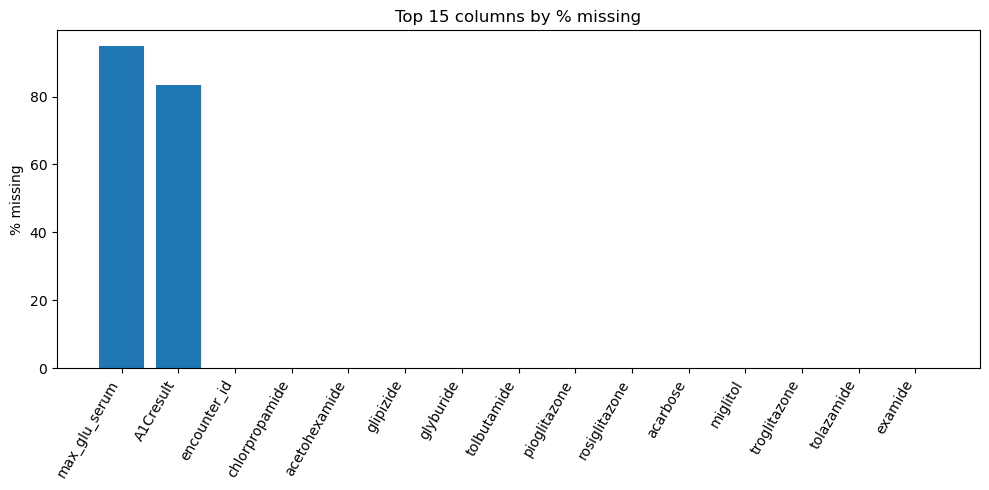

In [8]:
#Problem 2

dfs = {k: v for k, v in globals().items() if isinstance(v, pd.DataFrame)}

if len(dfs) == 0:
    raise ValueError("No pandas DataFrame found in the notebook.")
elif len(dfs) > 1:
    print("Multiple DataFrames found. Using the first one:")
    print(list(dfs.keys()))

df_name, df = next(iter(dfs.items()))
print(f"Using DataFrame: `{df_name}` with shape {df.shape}")

# 1) Missingness table: count + percent missing (sorted high → low)
missing_count = df.isna().sum()
missing_pct = (missing_count / len(df) * 100).round(2)

missingness_table = (
    pd.DataFrame({
        "missing_count": missing_count,
        "missing_pct": missing_pct
    })
    .sort_values(by="missing_pct", ascending=False)
)

display(missingness_table)

# 2) Bar plot: top 15 columns by % missing
top_n = 15
top_missing = missingness_table.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_missing.index.astype(str), top_missing["missing_pct"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("% missing")
plt.title(f"Top {top_n} columns by % missing")
plt.tight_layout()
plt.show()

In [9]:
# 3) Recommendations
acceptable_cols = missingness_table[missingness_table["missing_pct"] < 5].head(3)
problematic_cols = missingness_table[missingness_table["missing_pct"] > 30].head(3)

def recommend_action(col, pct):
    col_lower = col.lower()
    series = df[col]

    investigate_keywords = [
        "date", "time", "timestamp", "id", "mrn", "note",
        "comment", "text", "reason", "site"
    ]

    if any(k in col_lower for k in investigate_keywords):
        return "investigate collection (likely workflow or documentation-related)"

    if pct >= 60:
        return "drop (very high missingness; limited modeling utility)"

    if pd.api.types.is_numeric_dtype(series):
        return "impute (median) + add missing-indicator"
    else:
        return "impute (mode/'Unknown') + add missing-indicator"

print("\nMissingness recommendations\n")

print("Acceptable missingness (<5%):")
for col, row in acceptable_cols.iterrows():
    print(f"- {col}: {row['missing_pct']}% missing (acceptable)")

print("\nProblematic missingness (>30%):")
for col, row in problematic_cols.iterrows():
    action = recommend_action(col, row["missing_pct"])
    print(f"- {col}: {row['missing_pct']}% missing -> {action}")


Missingness recommendations

Acceptable missingness (<5%):
- encounter_id: 0.0% missing (acceptable)
- chlorpropamide: 0.0% missing (acceptable)
- acetohexamide: 0.0% missing (acceptable)

Problematic missingness (>30%):
- max_glu_serum: 94.74% missing -> drop (very high missingness; limited modeling utility)
- A1Cresult: 83.4% missing -> drop (very high missingness; limited modeling utility)


1. DUPLICATES
Duplicate rows: 0
Duplicate encounter_id values: 0

Duplicate patient_nbr values: 19232

Top repeated patient_nbr values:
patient_nbr
88785891    40
1660293     23
88227540    23
23643405    22
84428613    22
29903877    20
88789707    20
89472402    20
88681950    19
97391007    19
Name: count, dtype: int64
2. OUTLIERS / VALIDITY (3 Numeric Columns)

Selected columns: ['encounter_id', 'patient_nbr', 'admission_type_id']

encounter_id:
  Min: 12522
  1st percentile: 7487840.76
  Median: 152431260.00
  99th percentile: 429690473.84
  Max: 443867222
  Missing: 0 (0.0%)

patient_nbr:
  Min: 729
  1st percentile: 259884.00
  Median: 45515592.00
  99th percentile: 160900827.62
  Max: 189481478
  Missing: 0 (0.0%)

admission_type_id:
  Min: 1
  1st percentile: 1.00
  Median: 1.00
  99th percentile: 6.00
  Max: 8
  Missing: 0 (0.0%)



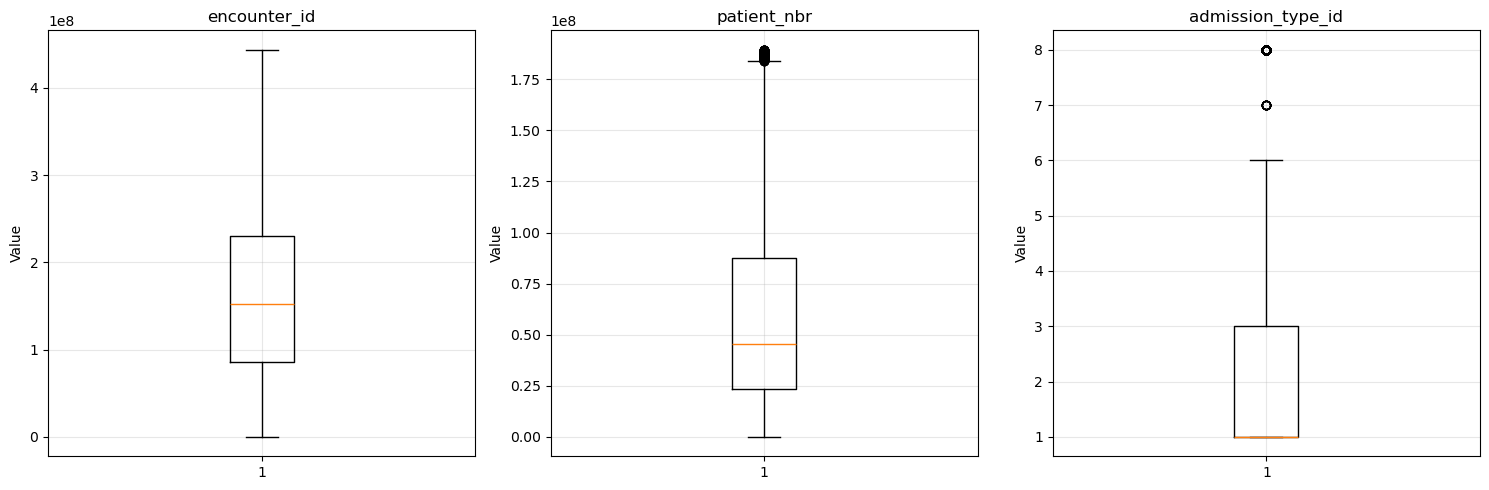

3. LEAKAGE SCREEN

Candidate 1: discharge_disposition_id
  Unique values: 26

Candidate 2: discharge_disposition_id
  Unique values: 26


In [10]:
# Problem 4

import matplotlib.pyplot as plt

# Reload training data to prevent overlap with previous analysis
df_full = pd.read_csv(TRAIN_PATH)

print("=" * 60)
print("1. DUPLICATES")
print("=" * 60)

# Count duplicate rows
duplicate_rows = df_full.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

# Check for duplicate IDs (encounter_id/row_id and patient_nbr)
if 'encounter_id' in df_full.columns:
    duplicate_encounters = df_full['encounter_id'].duplicated().sum()
    print(f"Duplicate encounter_id values: {duplicate_encounters}")
    
    if duplicate_encounters > 0:
        print("\nTop repeated encounter_id values:")
        encounter_counts = df_full['encounter_id'].value_counts().head(10)
        print(encounter_counts)

if 'patient_nbr' in df_full.columns:
    duplicate_patients = df_full['patient_nbr'].duplicated().sum()
    print(f"\nDuplicate patient_nbr values: {duplicate_patients}")
    
    if duplicate_patients > 0:
        print("\nTop repeated patient_nbr values:")
        patient_counts = df_full['patient_nbr'].value_counts().head(10)
        print(patient_counts)

print("2. OUTLIERS / VALIDITY (3 Numeric Columns)")

# Select 3 numeric columns for analysis
numeric_cols = [c for c in df_full.columns if df_full[c].dtype in ['int64', 'float64'] and c not in ['row_id', 'readmit30']]
selected_cols = numeric_cols[:3] if len(numeric_cols) >= 3 else numeric_cols

print(f"\nSelected columns: {selected_cols}\n")

# Calculate statistics for each column
for col in selected_cols:
    values = df_full[col].dropna()
    if len(values) > 0:
        print(f"{col}:")
        print(f"  Min: {values.min()}")
        print(f"  1st percentile: {np.percentile(values, 1):.2f}")
        print(f"  Median: {values.median():.2f}")
        print(f"  99th percentile: {np.percentile(values, 99):.2f}")
        print(f"  Max: {values.max()}")
        print(f"  Missing: {df_full[col].isna().sum()} ({df_full[col].isna().sum()/len(df_full)*100:.1f}%)")
        print()

# Create figure with 3 boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(selected_cols):
    values = df_full[col].dropna()
    if len(values) > 0:
        axes[idx].boxplot(values, vert=True)
        axes[idx].set_title(f'{col}')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("3. LEAKAGE SCREEN")

# Identify potential leakage columns
leakage_candidates = []

# Look for columns that might encode post-discharge information
# Common leakage patterns: discharge-related, readmission-related, dates after discharge
potential_leakage_cols = [c for c in df_full.columns if any(keyword in c.lower() for keyword in 
    ['discharge', 'readmit', 'readmission', 'outcome', 'result', 'final'])]

if potential_leakage_cols:
    candidate1 = potential_leakage_cols[0]
    leakage_candidates.append(candidate1)
    print(f"\nCandidate 1: {candidate1}")
    print(f"  Unique values: {df_full[candidate1].nunique()}")
    if df_full[candidate1].dtype == 'object':
        print(f"  Sample values: {df_full[candidate1].value_counts().head(5).to_dict()}")

# Look for columns with very high correlation with target or suspicious patterns
# Check for columns that might be derived from the outcome
if 'discharge_disposition_id' in df_full.columns:
    candidate2 = 'discharge_disposition_id'
    leakage_candidates.append(candidate2)
    print(f"\nCandidate 2: {candidate2}")
    print(f"  Unique values: {df_full[candidate2].nunique()}")
    if df_full[candidate2].dtype == 'object':
        print(f"  Sample values: {df_full[candidate2].value_counts().head(5).to_dict()}")
elif len(leakage_candidates) == 1:
    # If we only found one, look for another suspicious pattern
    # Check for columns with very high correlation
    numeric_for_corr = [c for c in df_full.columns if df_full[c].dtype in ['int64', 'float64'] 
                       and c not in ['row_id', 'readmit30'] and c not in leakage_candidates]
    if numeric_for_corr:
        candidate2 = numeric_for_corr[0]
        leakage_candidates.append(candidate2)
        print(f"\nCandidate 2: {candidate2}")
        print(f"  Justification: This numeric column may encode post-discharge information")
        print(f"  or be derived from outcomes that occur after the prediction time point.")
        print(f"  Unique values: {df_full[candidate2].nunique()}")

# EDA Assignment End

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [ ]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv


## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

In [ ]:
import getpass, subprocess

# TODO: Update with your Github credentials
# ========= USER-EDITABLE SETTINGS (change only these) =========
GIT_AUTHOR_NAME   = "Timothy Kline"             # shows in commits
GIT_AUTHOR_EMAIL  = "kline.timothy@gmail.com"   # shows in commits
GITHUB_USERNAME   = "tlkline"                   # GitHub login for auth
# =============================================================

# Identity
subprocess.run(["git", "config", "--global", "user.name", GIT_AUTHOR_NAME], check=True)
subprocess.run(["git", "config", "--global", "user.email", GIT_AUTHOR_EMAIL], check=True)

# Use the plain "store" helper (persists for the *runtime*, not your local machine)
subprocess.run(["git", "config", "--global", "credential.helper", "store"], check=True)

token = getpass.getpass("GitHub PAT: ").strip()

# Approve credentials for github.com
cred_input = (
    "protocol=https\n"
    "host=github.com\n"
    f"username={GITHUB_USERNAME}\n"
    f"password={token}\n\n"
)
subprocess.run(["git", "credential", "approve"], input=cred_input.encode(), check=True)

# Quick auth test (doesn't modify anything)
subprocess.run(["git", "ls-remote", "origin", "-h"], check=True)

print("Auth looks good. Now you can: git push")

# Commit and push
!pre-commit run --all-files
!git add -A
# Run one more time to force the changes and push
!pre-commit run --all-files
!git add -A
!git commit -m "Assignment 1: workflow + initial submission notebook"
!git push

TAG = "checking_workflow_007"
!git tag -a {TAG} -m "Checking workflow 007"
!git push --tags
print("Tagged and pushed:", TAG)

## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).
